# Skip-gram Negative Sampling with Tensorflow 

## Resources
* Mikolov et al (2013a) [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf) 
* Mikolov et al (2013b) [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/pdf/1310.4546.pdf)
* CS224n Lecture (2018) on [Word Vectors 1](http://web.stanford.edu/class/cs224n/lectures/lecture2.pdf)
* Tensorflow Tutorial [Vector Representations of Words](https://www.tensorflow.org/tutorials/representation/word2vec)
* Word2Vec Tutorial by Chris McCormick (2016): [The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
* Word2Vec Tutorial by Andy Thomas (2017) [Word2Vec word embedding tutorial in Python and TensorFlow](http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/) 
* Word Embeddings Series by Sebastian Ruder (2016-2017) [On word embeddings and a series of excellent posts](http://ruder.io/tag/word-embeddings/)

In [1]:
import tensorflow as tf
import numpy as np

import collections
import random
import os
import sys
import time
import urllib
import zipfile

from datetime import datetime
from tempfile import gettempdir

from tensorboard.plugins import projector

In [2]:
print('Tensorflow', tf.__version__)
print('Python', sys.version)

Tensorflow 1.9.0
Python 3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


## Download and read the data from file
Helper functions adapted from [Tensorflow's Github repository](https://github.com/tensorflow/tensorflow/blob/r1.9/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)

In [3]:
def maybe_download(url, filename, expected_bytes):
    "Download the file if not present, and make sure it's the right size."    
    local_filename = os.path.join(gettempdir(), filename)
    if not os.path.exists(local_filename):
        local_filename, _ = urllib.request.urlretrieve(url + filename, local_filename)
        statinfo = os.stat(local_filename)
        if statinfo.st_size == expected_bytes:
            print('Found and verified', filename)
        else:
            print(statinfo.st_size)
            raise Exception('Failed to verify ' + local_filename + 
                            '. Can you get to it with a browser?')
    return local_filename


def read_data(filename):
    "Extract the file enclosed in a zip file as a list of words (strings)."
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


def normalize_counter(counter):
    "Used to normalize the counts/frequency"
    total = sum(counter.values())
    for w_idx in counter:
        counter[w_idx] /= total
    return counter


def build_dataset(words, n_words):
    "Process raw inputs into a dataset"
    count = collections.Counter(words).most_common(n_words - 1)
    dictionary = {'UNK': 0}
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    for word in words:
        index = dictionary.get(word, 0) # words outside of vocab replaced with UNK
        data.append(index)
    count = normalize_counter(collections.Counter(data)).most_common(n_words)
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


### Text8
http://mattmahoney.net/dc/textdata.html

In [4]:
filename = maybe_download(
    url='http://mattmahoney.net/dc/', filename='text8.zip', expected_bytes=31344016)

## Process the data and build the dictionaries

In [5]:
data = read_data(filename)
original_len = len(data)
print('Total number of words in text: {:,}.'.format(original_len))

MAX_VOCAB = 50000    #  train on the most common 50,000 words in the text
"""
data               :  list of IDs(int) representing the original words in text
count              :  maps IDs(int) to normalized count/frequency in text
dictionary         :  maps words(strings) to their IDs(int)
reverse_dictionary :  maps IDs(int) to words(strings)
"""
data, count, dictionary, reverse_dictionary = build_dataset(data, MAX_VOCAB)
print('The 5 most common words (normalized counts):', 
      [(reverse_dictionary[i], c) for i, c in count[:5]])
print('First 10 words in text:', 
      data[:10], [reverse_dictionary[i] for i in data[:10]])

Total number of words in text: 17,005,207.
The 5 most common words (normalized counts): [('the', 0.06241594118789615), ('of', 0.034911483288618594), ('UNK', 0.024603699325741815), ('and', 0.02450008400368193), ('one', 0.02421399516042351)]
First 10 words in text: [5242, 3081, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


### Calculate frequencies for negative sampling and subsampling of frequent words
Section 2.2 of Mikolov et al (2013b)

In [6]:
def build_unigrams_dist(count):
    'Returns list of normalized frequencies per word in vocab'
    unigrams_dist = [0] * MAX_VOCAB
    for w_idx, count in count:
        unigrams_dist[w_idx] = count
    return unigrams_dist


In [7]:
unigram_dist = build_unigrams_dist(count) # used in negative sampling

### Subsampling of frequent words
Section 2.3 of Mikolov et al (2013b) 

In [8]:
def build_subsampling_dict(count, t=1e-3):
    "Source: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling"
    "Also: https://groups.google.com/d/msg/word2vec-toolkit/pE2qLbgpuys/F8ZQztKIfYUJ"
    return {w_idx: (np.sqrt(f/t) + 1)*(t/f) for w_idx, f in count}


def subsample_words(data, count):
    "Source: https://github.com/chrisjmccormick/word2vec_commented/blob/master/word2vec.c"
    subsampler = build_subsampling_dict(count)
    return [w for w in data 
            if subsampler[w] >= 1 or subsampler[w] >= random.random()]
    

In [9]:
data = subsample_words(data, count)
difference = original_len - len(data)

print('Original text length: {:,} words.'.format(original_len))
print('Subsampled text length: {:,} words.'.format(len(data)))
print('Dropped {:.2f}% words ({:,} words)'.format(difference* 100 / original_len, difference))

Original text length: 17,005,207 words.
Subsampled text length: 12,502,036 words.
Dropped 26.48% words (4,503,171 words)


### Training samples

In [10]:
def generate_windows(batch_size, skip_window):
    'Generates list of different sized windows (the R term in 2013a paper)'
    windows = []
    while sum(windows) < batch_size/2:  # each window generates size x 2 samples
        windows.append(random.randint(1, skip_window)) # randomly sample size
    windows[-1] -= sum(windows) - int(batch_size/2)
    return windows


"""
The original word2vec in C uses SGD without mini-batches.
See: https://groups.google.com/forum/#!topic/word2vec-toolkit/Un_E2eLH9Ek
To increase speed, they use CPU multi-threading instead. 
"""
def generate_batch_skipgram(batch_size, skip_window):
    """
    Returns:
    batch: shape=(batch_size,) center words (repeated based on window size)
    labels: shape=(batch_size, 1) context/target words
    data_index: position of last word processed (in the original text)
    """
    batch, labels = [], []
    data_index = skip_window
    while data_index + skip_window < len(data):
        windows = generate_windows(batch_size, skip_window)
        for window in windows:
            span = 2*window + 1
            buffer = data[data_index-window:data_index+window+1]
            context_words = [w for w in range(span) if w != window]
            for context_word in context_words:
                batch.append(buffer[window])
                labels.append(buffer[context_word])
                if len(batch) == batch_size:
                    yield (np.array(batch),
                           np.expand_dims(np.array(labels), 1),
                           data_index)
                    batch, labels = [], []
            data_index += 1
            if data_index + skip_window == len(data): # reached end of text
                break
    if batch and labels:
        yield np.array(batch), np.expand_dims(np.array(labels), 1), data_index


In [11]:
print(data[:6], [reverse_dictionary[i] for i in data[:8]])
batch, labels, data_index = next(generate_batch_skipgram(batch_size=8, skip_window=2))
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], 
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])
print('Position of last word processed:', data_index)

[5242, 3081, 12, 195, 2, 3137] ['anarchism', 'originated', 'as', 'term', 'of', 'abuse', 'first', 'used']
12 as -> 5242 anarchism
12 as -> 3081 originated
12 as -> 195 term
12 as -> 2 of
195 term -> 12 as
195 term -> 2 of
2 of -> 195 term
2 of -> 3137 abuse
Position of last word processed: 4


## Set the hyperparameter values

* Code commented by Chris McCormick (2016) [word2vec_commented](https://github.com/chrisjmccormick/word2vec_commented/blob/master/word2vec.c)
* Further reading: Caselles-Dupré et al (2018) [Word2vec applied to Recommendation: Hyperparameters Matter](https://arxiv.org/pdf/1804.04212)

In [18]:
batch_size = 512       # number of training samples to process in parallel
learning_rate = 5e-3   # Learning rate with RMSProp optimizer
skip_window = 10       # max number of words to consider each side of center word
embedding_size = 200   # dimension of the embedding vector.
k_negative = 20        # number of negative samples per correct sample.
                       # see https://github.com/tensorflow/tensorflow/issues/17949
ns_exp = 0.75          # exponent to shape the negative sampling distribution

## Select validation set for monitoring training progress 

In [13]:
valid_size = 16       # random set of words to evaluate training progress
valid_window = 100    # pick from most common 100 words to observe progress

In [14]:
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

## Building the Tensorflow Graph 

In [22]:
graph = tf.Graph()
with graph.as_default(): 
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[None])
        train_labels = tf.placeholder(tf.int64, shape=[None, 1])
        valid_dataset = tf.constant(valid_examples, tf.int32)
    
    with tf.name_scope('embeddings'):
        embeddings = tf.get_variable('embed_matrix', shape=(MAX_VOCAB, embedding_size), 
                                     initializer=tf.random_uniform_initializer(-1.0, 1.0))
        embedded_inputs = tf.nn.embedding_lookup(embeddings, train_inputs)
        
    with tf.name_scope('weights'):
        softmax_w = tf.get_variable('softmax_w', shape=(MAX_VOCAB, embedding_size),
                                    initializer=tf.truncated_normal_initializer(
                                        stddev=1.0/embedding_size**0.5))
        softmax_b = tf.get_variable('softmax_b', shape=(MAX_VOCAB),
                                    initializer=tf.zeros_initializer())
    
    # Tensorflow implementation of negative sampling.
    # Construct a candidate sampler and use it with a sampled loss function.
    # See https://www.tensorflow.org/api_guides/python/nn#Candidate_Sampling
    with tf.name_scope('loss'):
        sampler = tf.nn.fixed_unigram_candidate_sampler(true_classes=train_labels,
                                                        num_true=1,
                                                        num_sampled=k_negative,
                                                        unique=True,
                                                        range_max=MAX_VOCAB,
                                                        distortion=ns_exp,  
                                                        num_reserved_ids=0,     
                                                        unigrams=unigram_dist)
        
        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_w,
                                                         biases=softmax_b,
                                                         labels=train_labels,
                                                         inputs=embedded_inputs,
                                                         num_sampled=k_negative,
                                                         num_classes=MAX_VOCAB,
                                                         sampled_values=sampler))
    tf.summary.scalar('loss', loss)
    
    with tf.name_scope('optimizer'):
        # original C code for word2vec uses SGD with linear decay
        train_op = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)
    
    # Find embeddings most similiar to the validation examples (cosine)  
    with tf.name_scope('similarity'):
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
        
    merged = tf.summary.merge_all()
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    

In [23]:
def get_logdir():
    root_logdir = 'tf_logs'
    if not os.path.exists(root_logdir):
        os.makedirs(root_logdir)
    now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
    return "{}/run_{}/".format(root_logdir, now)

## Create session and train model 

In [24]:
num_epochs = 2          # num of times to go through text
log_dir = get_logdir()

start = time.perf_counter()

with tf.Session(graph=graph) as sess:
    writer = tf.summary.FileWriter(log_dir, graph)
    init.run()         
    print('Initialized.')
    
    for epoch in range(num_epochs):
        print('Training: epoch', epoch + 1)
        average_loss = 0
        for step, (batch_inputs, batch_labels, data_index) in enumerate(
            generate_batch_skipgram(batch_size, skip_window)):
            feed_dict = {train_inputs: batch_inputs, 
                         train_labels: batch_labels}
            run_metadata = tf.RunMetadata()
            _, summary, loss_val = sess.run([train_op, merged, loss],
                                            feed_dict=feed_dict,
                                            run_metadata=run_metadata)
            average_loss += loss_val
            writer.add_summary(summary, step)
                                
            if step % 10000 == 0:
                if step > 0:
                    average_loss /= 10000
                print('Average loss at step {}: {}'.format(step, average_loss))
                average_loss = 0
            
            # most similar words for validation set (expensive exercise)
            if step % 50000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest words to "{}": '.format(valid_word)
                    close_words = [reverse_dictionary[nearest[k]]
                                   for k in range(top_k)]
                    print(log_str, ', '.join(close_words))
            
            # Add metadata to visualize the graph for the final run
            if (epoch + 1 == num_epochs) and (data_index - skip_window == len(data) - 1):
                writer.add_run_metadata(run_metadata, 'step{}'.format(step))

    final_embeddings = normalized_embeddings.eval()
    
    # Save embedding labels (the words) for projecting in tensorboard
    with open(log_dir + '/metadata.tsv', 'w') as f:
        for i in range(MAX_VOCAB):
            f.write(reverse_dictionary[i] + '\n')
    
    # Save model checkpoints
    saver.save(sess, os.path.join(log_dir, 'model.ckpt'))
    
    # Create tensorboard configuration for the embeddings
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join(log_dir, 'metadata.tsv')
    projector.visualize_embeddings(writer, config)
    
writer.close()
elapsed = time.perf_counter() - start
print('Finished training in {:.3f} minutes'.format(elapsed/60))

Initialized.
Training: epoch 1
Average loss at step 0: 4.9314470291137695
Nearest words to "six":  shiga, gaussian, precepts, hariri, centralizing, paradoxical, bernardo, frankie
Nearest words to "into":  bahia, contra, centimes, drumming, fripp, quoted, yetzirah, theogony
Nearest words to "history":  motionless, regiments, swede, bukovina, oblast, arse, courant, acheron
Nearest words to "years":  realizes, survey, zionism, jordanes, crash, mapmaking, warships, dialects
Nearest words to "for":  singhasari, ims, tomorrow, feeble, orl, cockpit, anion, ioc
Nearest words to "world":  differs, reworked, negotiate, arbuckle, vainly, powerpoint, proofing, monogatari
Nearest words to "his":  bearings, epiphenomenalism, japonic, immanence, man, constitutionally, conectiva, wafers
Nearest words to "has":  marines, fleischmann, nexgen, smiles, mortars, actors, voyage, diazepam
Nearest words to "zero":  serene, arg, phage, condemning, ballista, duckling, write, publishing
Nearest words to "people"

Average loss at step 260000: 2.933665074904263
Training: epoch 2
Average loss at step 0: 2.971414804458618
Nearest words to "six":  five, seven, eight, four, three, zero, two, one
Nearest words to "into":  through, form, out, donuts, tuition, preclear, dec, down
Nearest words to "history":  links, external, see, article, modern, list, early, includes
Nearest words to "years":  year, months, days, decades, age, wallpaper, period, absorbs
Nearest words to "for":  a, and, in, of, as, the, UNK, also
Nearest words to "world":  advertisers, shank, eccentricities, rhode, paintings, country, unscientific, scientologists
Nearest words to "his":  s, he, of, him, their, her, and, its
Nearest words to "has":  had, have, its, is, since, unilateral, was, identifies
Nearest words to "zero":  two, four, six, three, five, eight, one, seven
Nearest words to "people":  they, who, their, about, those, deaths, themselves, chez
Nearest words to "called":  known, referred, formed, form, like, group, between,

Average loss at step 260000: 2.860580876168981
Finished training in 38.205 minutes


## Plot the embeddings using t-SNE 
Source: https://github.com/tensorflow/tensorflow/blob/r1.9/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [25]:
%matplotlib inline
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')
    plt.savefig(filename)
    plt.show()

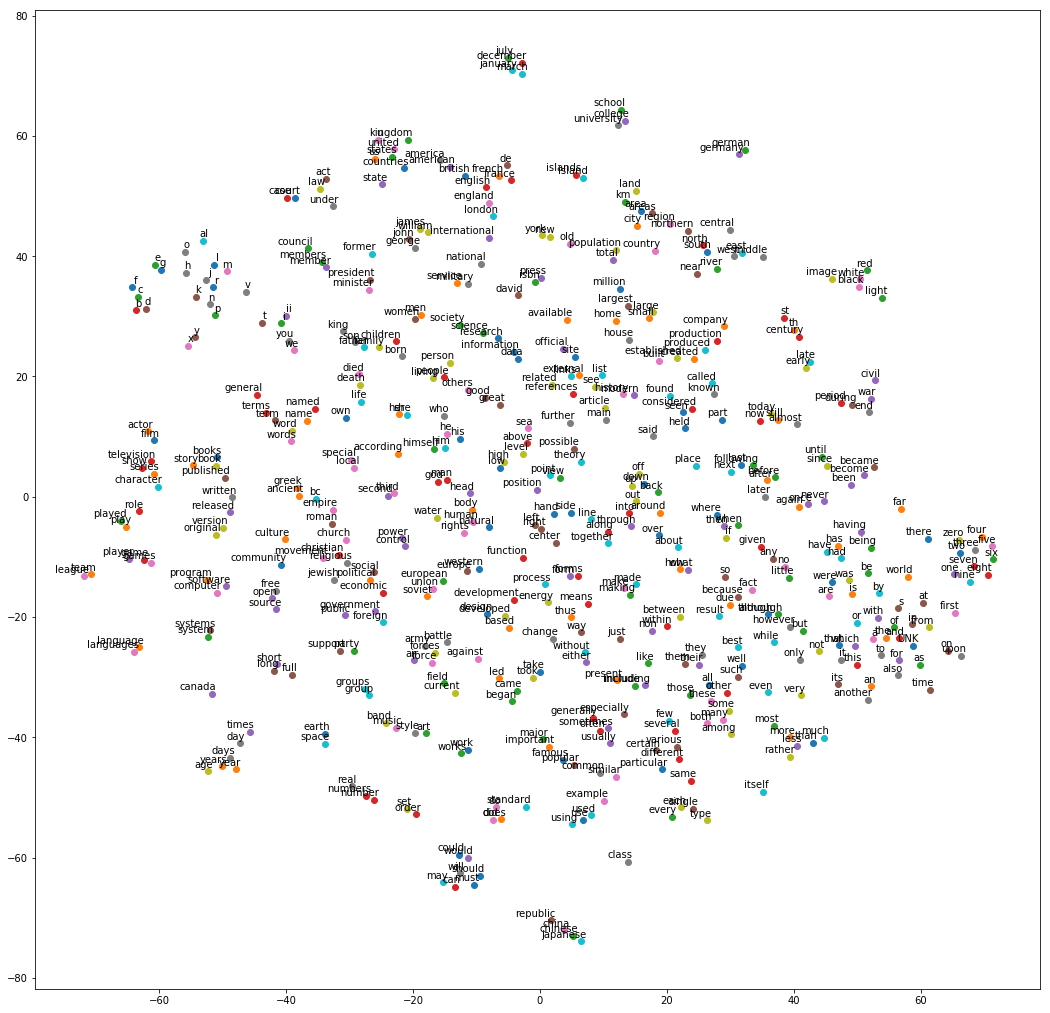

In [26]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in range(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)